In [1]:
    #Istalling the dependencies needed.
    !pip install transformers datasets pandas matplotlib seaborn shap scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvid

In [3]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os

# Locate the path to emotions.txt inside the GoEmotions dataset folder
emotion_file_path = None
for root, dirs, files in os.walk("/kaggle/input/goemotions"):
    for file in files:
        if file.lower() == "emotions.txt":
            emotion_file_path = os.path.join(root, file)
            break

# Load emotion labels from emotions.txt
if emotion_file_path:
    with open(emotion_file_path, "r") as f:
        labels = [line.strip() for line in f.readlines()]
    print(f" Loaded {len(labels)} emotion labels from:\n{emotion_file_path}")
else:
    raise FileNotFoundError(" Could not find emotions.txt in the dataset!")

# Load the training split of GoEmotions dataset
df = pd.read_csv("/kaggle/input/goemotions/data/train.tsv", sep="\t", header=None, names=["text", "labels", "id"])

# Convert label IDs (as string) to actual emotion names
def decode_labels(label_str, label_list):
    label_ids = list(map(int, label_str.split(",")))
    return [label_list[i] for i in label_ids]

# Apply decoding to the 'labels' column
df['decoded_labels'] = df['labels'].apply(lambda x: decode_labels(x, labels))

# Classify emotions for a batch of texts using a threshold
def classify_emotions_batch(texts, threshold=0.3):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.sigmoid(logits).cpu().numpy()

    # Return emotion-probability pairs that exceed the threshold
    return [
        [(label, round(prob, 3)) for label, prob in zip(labels, row) if prob >= threshold]
        for row in probs
    ]


 Loaded 28 emotion labels from:
/kaggle/input/goemotions/data/emotions.txt


In [4]:
#Load the model and tokenizer.
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(" Model and tokenizer loaded successfully!")


tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

2025-06-18 11:24:49.914781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750245890.135255      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750245890.201663      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

 Model and tokenizer loaded successfully!


In [5]:
import os
import json
import pandas as pd
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt

# Load emotion labels
with open("/kaggle/input/goemotions/data/emotions.txt", "r") as f:
    labels = [line.strip() for line in f.readlines()]

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained("SamLowe/roberta-base-go_emotions")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Emotion classifier
def classify_emotions_batch(texts, threshold=0.3):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
        probs = torch.sigmoid(logits).cpu().numpy()
    return [[(label, round(p, 3)) for label, p in zip(labels, row) if p >= threshold] for row in probs]

# Load datasets
def load_full_articles(path, topic):
    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            item = json.loads(line)
            text = item.get("text", "").strip()
            if not text:
                continue
            records.append({
                "doc_id": item.get("doc_id"),
                "topic": topic,
                "text": text,
                "source": item.get("source"),
                "section": None,
                "date": item.get("date")
            })
    return pd.DataFrame(records)

# Dataset paths
paths = {
    "smoking": "/kaggle/input/news-to-analyze/smoking.jsonl",
    "samesex": "/kaggle/input/news-to-analyze/samesex.jsonl",
    "immigration": "/kaggle/input/news-to-analyze/immigration.jsonl"
}

# Load & classify
df_all = pd.concat([load_full_articles(path, topic) for topic, path in paths.items()], ignore_index=True)
df_all = df_all[df_all["text"].str.strip().astype(bool)]
df_all["date"] = pd.to_datetime(df_all["date"], errors="coerce")

texts = df_all["text"].tolist()
emotions_all = []
batch_size = 8

for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i + batch_size]
    emotions_all.extend(classify_emotions_batch(batch))

df_all["emotions"] = emotions_all

# Extract emotion list & top emotion
df_all["emotion_list"] = df_all["emotions"].apply(lambda x: [e[0] for e in x] if isinstance(x, list) else [])
df_all["main_emotion"] = df_all["emotions"].apply(lambda x: x[0][0] if isinstance(x, list) and len(x) > 0 else None)

# Clean source → leaning
source_leaning_map = {
    "new york times": "left", "washington post": "left", "la times": "left", "boston globe": "left",
    "fox news": "right", "washington times": "right", "new york post": "right",
    "usa today": "center", "associated press": "center", "reuters": "center", "palm beach post (florida)": "center"
}
df_all["source_clean"] = df_all["source"].str.lower()
df_all["leaning"] = df_all["source_clean"].map(source_leaning_map).fillna("unknown")


100%|██████████| 42/42 [00:10<00:00,  3.92it/s]


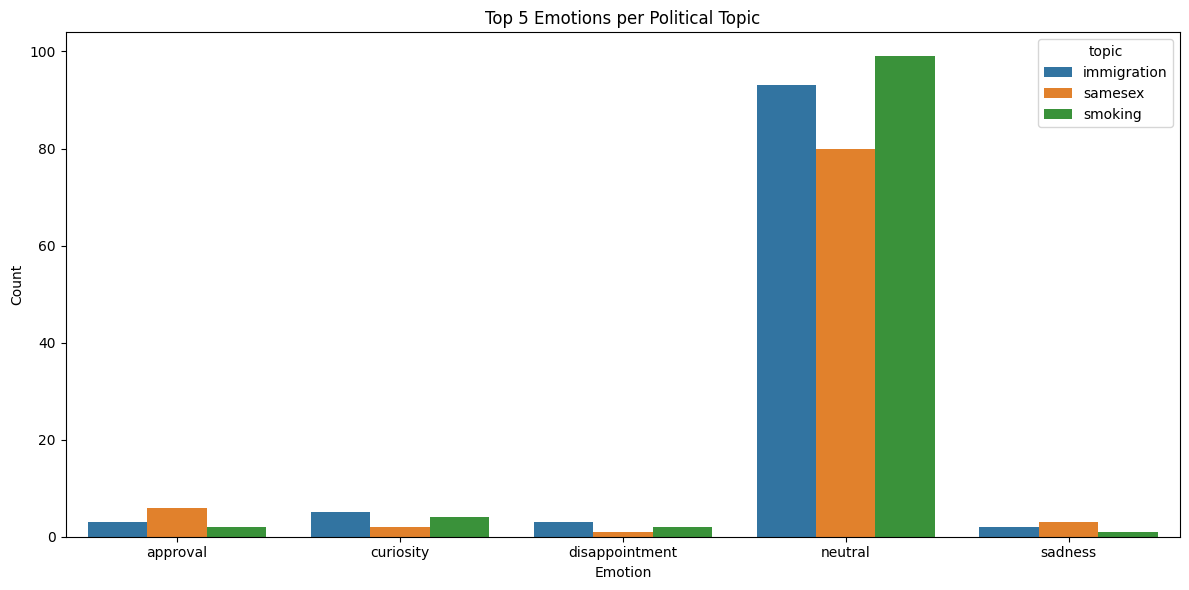

In [8]:
# ==================================
# PLOT 1 — Top Emotions by Topic
# ==================================
filtered = df_all[df_all["main_emotion"].notna() ]
counts_topic = filtered.groupby(["topic", "main_emotion"]).size().reset_index(name="count")
top5 = counts_topic.groupby("main_emotion")["count"].sum().nlargest(5).index
top_data = counts_topic[counts_topic["main_emotion"].isin(top5)]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_data, x="main_emotion", y="count", hue="topic")
plt.title("Top 5 Emotions per Political Topic")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

We observe that neutral is the predominant emotion in most news articles. This aligns with expectations, as journalistic writing typically maintains a neutral tone. To better highlight the distribution of other emotions, the plot below excludes the neutral category for improved clarity.

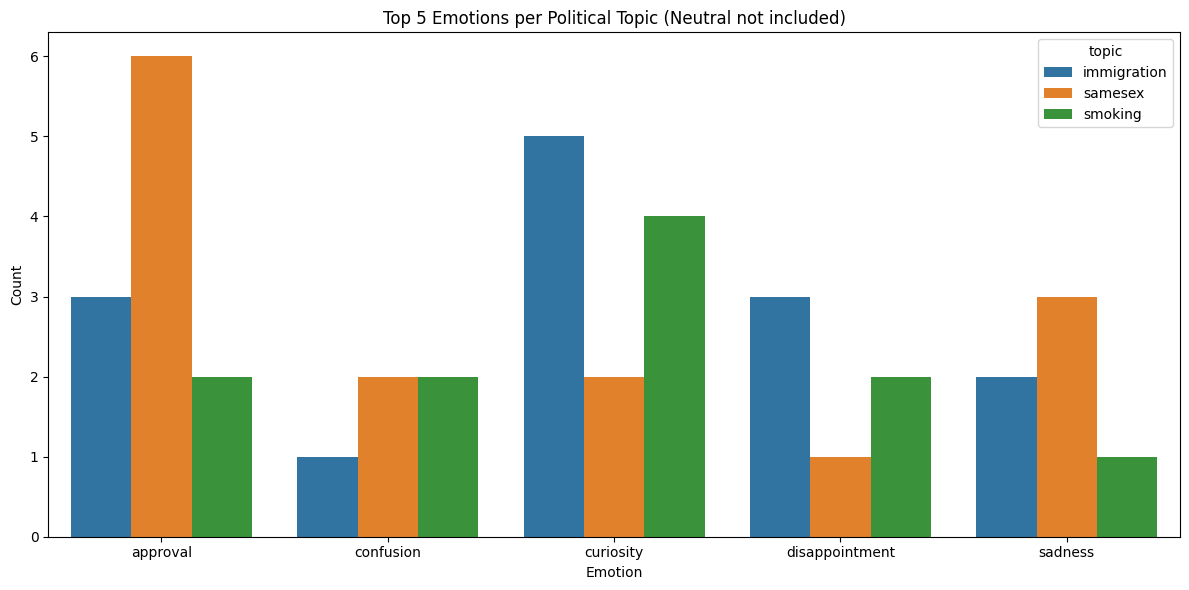

In [10]:
filtered = df_all[df_all["main_emotion"].notna() & (df_all["main_emotion"] != "neutral") ]
counts_topic = filtered.groupby(["topic", "main_emotion"]).size().reset_index(name="count")
top5 = counts_topic.groupby("main_emotion")["count"].sum().nlargest(5).index
top_data = counts_topic[counts_topic["main_emotion"].isin(top5)]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_data, x="main_emotion", y="count", hue="topic")
plt.title("Top 5 Emotions per Political Topic (Neutral not included)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

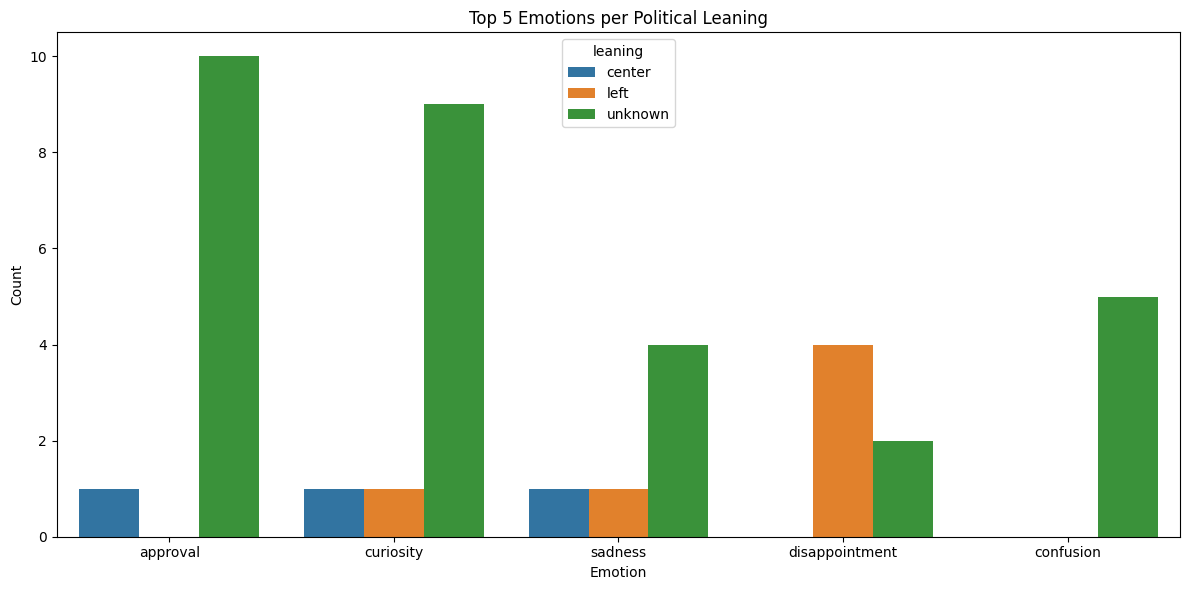

In [11]:
# ==================================
# PLOT 2 — Top Emotions by Leaning
# ==================================
counts_leaning = filtered.groupby(["leaning", "main_emotion"]).size().reset_index(name="count")
top_data2 = counts_leaning[counts_leaning["main_emotion"].isin(top5)]

plt.figure(figsize=(12, 6))
sns.barplot(data=top_data2, x="main_emotion", y="count", hue="leaning")
plt.title("Top 5 Emotions per Political Leaning")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

This bar chart illustrates the distribution of the **five most frequent non-neutral emotions across different political leanings** in news articles. The "neutral" emotion, while dominant overall, was excluded to improve clarity and focus on more emotionally charged expressions. We observe that articles with an "unknown" political leaning tend to evoke more "approval" and "curiosity," suggesting a potentially broad or ambiguous rhetorical appeal. In contrast, left-leaning content shows higher levels of "disappointment" and "sadness," pointing to a more critical or negative tone. Center-leaning articles display a relatively balanced emotional profile, consistent with moderate or less polarized reporting.

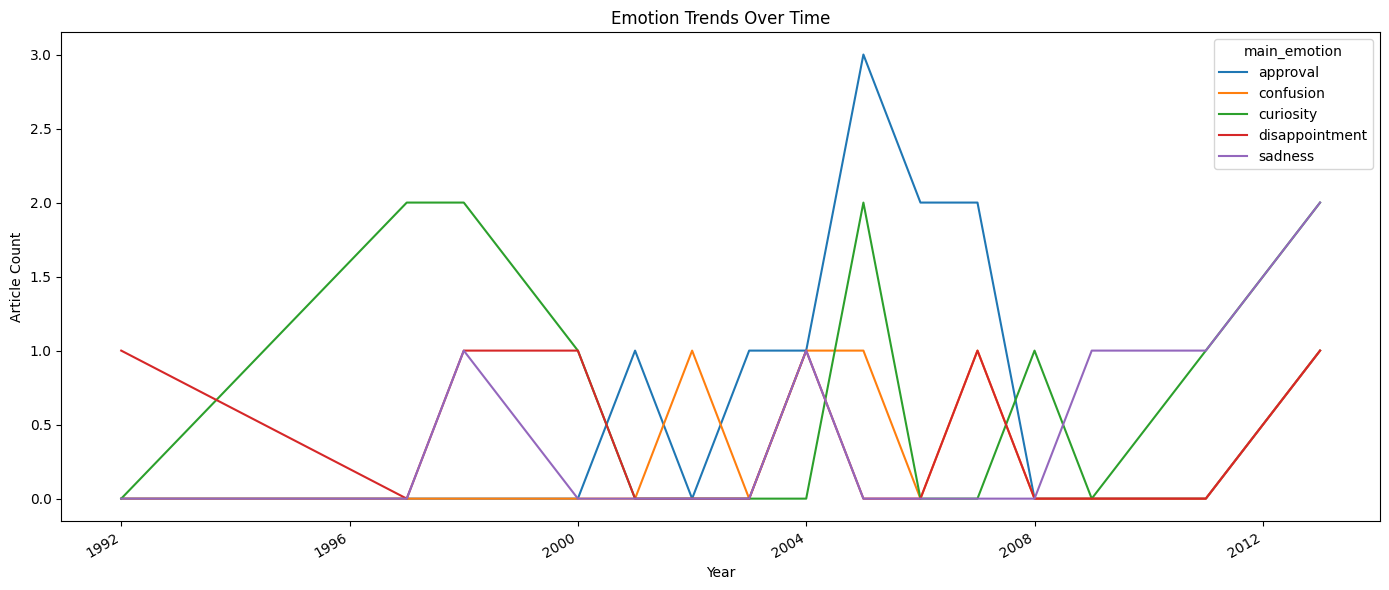

In [13]:
# ========================
# PLOT 3 — Emotion Timeline
# ========================
timeline = filtered[filtered["main_emotion"].isin(top5)]
timeline_counts = timeline.groupby([pd.Grouper(key="date", freq="YE"), "main_emotion"]).size().unstack().fillna(0)

timeline_counts.plot(figsize=(14, 6), title="Emotion Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Article Count")
plt.tight_layout()
plt.show()

This line chart tracks the **frequency of the five most common non-neutral emotions—approval, curiosity, disappointment, confusion, and sadness—in news articles over time**. Each line represents the yearly count of articles where one of these emotions is dominant. We observe that:

* Approval peaks sharply in the mid-2000s, indicating a temporary rise in positively framed narratives.

* Curiosity and disappointment show intermittent presence across years, suggesting shifting narrative tones likely tied to external events.

* Sadness increases steadily after 2010, potentially reflecting a more somber or crisis-oriented news environment.

* The fluctuations overall reveal how emotional framing in political discourse can vary in intensity and type over time, potentially correlating with major political or social developments.
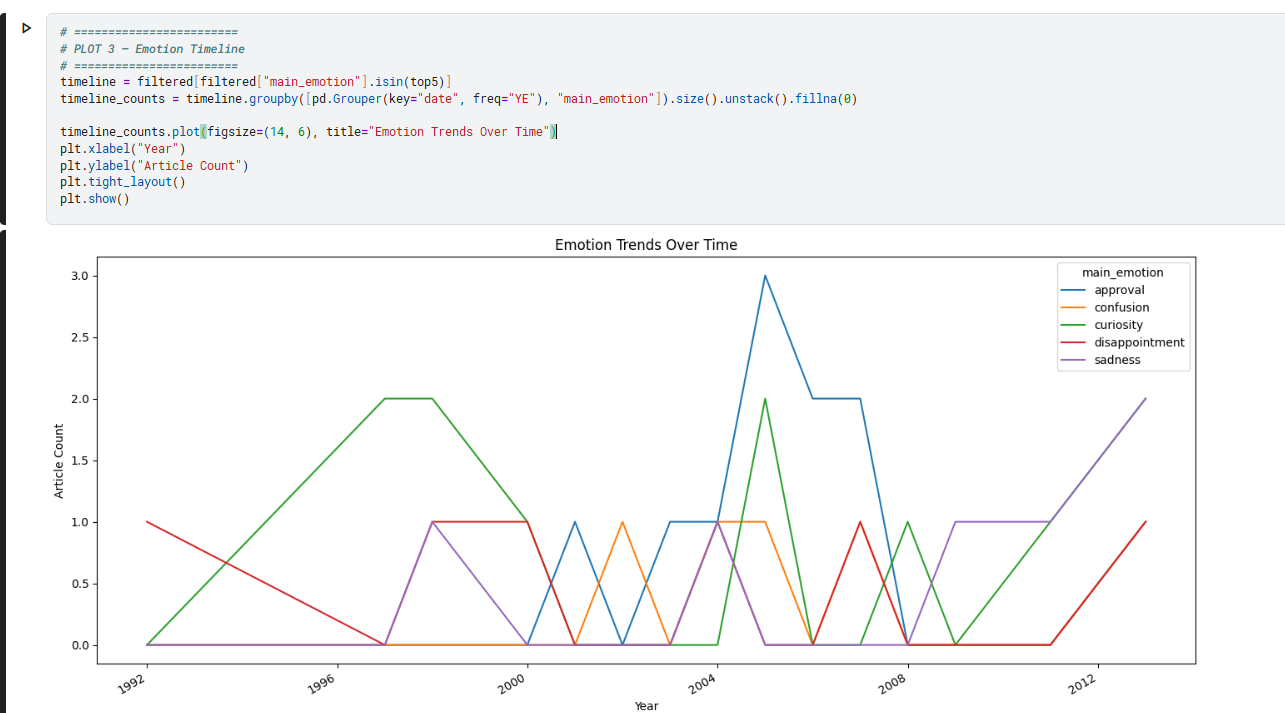

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import pandas as pd

# Filter out rows where 'emotion_list' is not a list or is empty
df_filtered = df_all[df_all["emotion_list"].apply(lambda x: isinstance(x, list) and len(x) > 0)]

# Group texts by (topic, emotion) pairs
emotion_texts = defaultdict(list)
for _, row in df_filtered.iterrows():
    topic = row["topic"]
    emotions = row["emotion_list"]
    text = row["text"]
    
    # For each emotion in the list, store the associated text under the (topic, emotion) key
    for emotion in emotions:
        emotion_texts[(topic, emotion)].append(text)

# Compute top TF-IDF trigger words for each (topic, emotion) group
summary_rows = []
for (topic, emotion), texts in emotion_texts.items():
    if len(texts) < 3:
        continue  # Skip groups with fewer than 3 texts (not enough data)

    # Create TF-IDF matrix for the texts, limited to top 1000 terms (excluding English stopwords)
    vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
    X = vectorizer.fit_transform(texts)

    # Average TF-IDF scores across all texts in the group
    tfidf_scores = X.mean(axis=0).A1

    # Get the indices of the top 5 words with highest TF-IDF scores
    top_indices = tfidf_scores.argsort()[::-1][:5]
    top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices]

    # Add the result to the summary table
    summary_rows.append({
        "Topic": topic,
        "Emotion": emotion,
        "Trigger Words": ", ".join(top_words)
    })

# Create a final DataFrame with all extracted trigger words
trigger_df = pd.DataFrame(summary_rows)
trigger_df.sort_values(by=["Topic", "Emotion"], inplace=True)

# Display the table 
print(trigger_df)



          Topic         Emotion                                  Trigger Words
8   immigration        approval           heating, tank, water, safety, energy
10  immigration       curiosity  apprenticeships, write, try, did, immigration
9   immigration  disappointment         alien, ukrainian, vents, film, romulus
7   immigration         neutral     said, republic, trump, people, immigration
4       samesex        approval           heating, tank, water, safety, energy
6       samesex       curiosity           global, india, trade, china, country
3       samesex         neutral           said, marriage, court, north, dakota
5       samesex         sadness           uribe, coote, kedik, colombian, said
1       smoking       curiosity                  write, did, try, watch, storm
2       smoking       gratitude  tobacco, smoking, billion, companies, related
0       smoking         neutral          said, tobacco, trump, smoking, people
